In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# run eagerly should be set to true. 
tf.config.run_functions_eagerly(True)

import copy


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df


# V4
def custom_metric(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    l = 1.5
    
    diff = y_true[:,0] - y_pred[:,0]
    
    w_true = y_true[:,1]
    w_pred = y_pred[:,1]
    
    # Weighted mean absolute error
    threshold = w_true * diff
    wae = step_function(threshold)*( (l + abs(w_true - w_pred)) * abs(diff)) \
            + (1 - step_function(threshold))*( (1/l) * abs(diff))
    wmae = sum(wae) / wae.shape[0]
    
    return wmae


2023-11-08 09:59:28.201351: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 09:59:28.226660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-08 09:59:29.139624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 09:59:29.143684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 09:59:29.143820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
90149,35357.47,35357.83,35342.75,35350.23,73596.36,2.081864,57,31,39764.7600,1.124869,35350.777,26,33831.605,0.956995,35351.723,2023-11-08 00:56:00
90150,35349.12,35361.76,35346.82,35352.53,70592.21,1.996857,63,27,27541.6210,0.779080,35352.188,36,43050.594,1.217777,35351.770,2023-11-08 00:57:00
90151,35351.44,35361.02,35343.74,35352.09,75369.22,2.132030,57,31,39824.4450,1.126539,35352.348,26,35544.780,1.005491,35350.770,2023-11-08 00:58:00
90152,35356.10,35359.78,35349.76,35353.62,57977.26,1.640046,40,24,30347.0500,0.858456,35351.125,16,27630.215,0.781590,35351.242,2023-11-08 00:59:00
90153,35360.02,35363.87,35358.59,35363.15,86356.00,2.442123,77,10,7187.6587,0.203272,35360.496,4,4148.450,0.117321,35359.812,2023-11-08 01:00:00


In [3]:
p1_close_price = btc_raw_df["close"].shift(1)
btc_raw_df["p1_gain"] = btc_raw_df["close"] / p1_close_price - 1.0
btc_raw_df

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain
1,25824.44,25831.18,25819.53,25825.24,95769.52,3.708438,72,41,53700.4500,2.079428,25825.186,31,42069.074,1.629010,25824.785,2023-09-02 12:11:00,NaN
2,25825.69,25831.18,25824.56,25825.60,84266.64,3.262884,61,24,28694.2970,1.111076,25825.957,37,55572.350,2.151808,25825.865,2023-09-02 12:12:00,0.000014
3,25825.46,25826.37,25820.69,25825.53,75424.89,2.920544,56,29,36727.9600,1.422152,25825.590,27,38696.934,1.498392,25825.506,2023-09-02 12:13:00,-0.000003
4,25825.41,25830.08,25824.86,25826.63,64327.65,2.490819,51,24,27203.9940,1.053362,25826.016,27,37123.660,1.437457,25825.879,2023-09-02 12:14:00,0.000043
5,25826.25,25831.17,25825.55,25826.26,66004.63,2.555701,44,24,33439.0300,1.294760,25826.838,20,32565.605,1.260941,25826.398,2023-09-02 12:15:00,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90149,35357.47,35357.83,35342.75,35350.23,73596.36,2.081864,57,31,39764.7600,1.124869,35350.777,26,33831.605,0.956995,35351.723,2023-11-08 00:56:00,-0.000120
90150,35349.12,35361.76,35346.82,35352.53,70592.21,1.996857,63,27,27541.6210,0.779080,35352.188,36,43050.594,1.217777,35351.770,2023-11-08 00:57:00,0.000065
90151,35351.44,35361.02,35343.74,35352.09,75369.22,2.132030,57,31,39824.4450,1.126539,35352.348,26,35544.780,1.005491,35350.770,2023-11-08 00:58:00,-0.000012
90152,35356.10,35359.78,35349.76,35353.62,57977.26,1.640046,40,24,30347.0500,0.858456,35351.125,16,27630.215,0.781590,35351.242,2023-11-08 00:59:00,0.000043


In [4]:
####################################
# Create Dataset with target value
####################################
predicting_points = 1
btc_df_with_target = btc_raw_df
target_column_to_predict = 'close'
f1_close = btc_raw_df[target_column_to_predict].shift(-predicting_points)
btc_df_with_target['f1_close'] = f1_close
btc_df_with_target.tail(10)

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,f1_close
90144,35326.42,35331.76,35307.88,35325.31,87222.67,2.469343,69,40,51058.8000,1.445534,35322.164,29,36163.875,1.023809,35322.555,2023-11-08 00:51:00,-0.000022,35338.12
90145,35327.40,35354.65,35325.97,35338.12,80100.21,2.266834,52,16,23153.4100,0.655324,35333.305,36,56946.805,1.611510,35335.777,2023-11-08 00:52:00,0.000363,35341.90
90146,35349.77,35357.23,35341.90,35341.90,79079.22,2.237264,58,30,33802.3240,0.956303,35348.810,28,45276.902,1.280961,35346.150,2023-11-08 00:53:00,0.000107,35351.61
90147,35340.88,35356.03,35340.74,35351.61,73992.70,2.093143,56,25,33268.4900,0.941116,35349.960,31,40724.215,1.152027,35349.680,2023-11-08 00:54:00,0.000275,35354.47
90148,35356.93,35367.35,35349.72,35354.47,77887.40,2.202995,57,37,50842.7930,1.438046,35355.668,20,27044.610,0.764949,35354.840,2023-11-08 00:55:00,0.000081,35350.23
90149,35357.47,35357.83,35342.75,35350.23,73596.36,2.081864,57,31,39764.7600,1.124869,35350.777,26,33831.605,0.956995,35351.723,2023-11-08 00:56:00,-0.000120,35352.53
90150,35349.12,35361.76,35346.82,35352.53,70592.21,1.996857,63,27,27541.6210,0.779080,35352.188,36,43050.594,1.217777,35351.770,2023-11-08 00:57:00,0.000065,35352.09
90151,35351.44,35361.02,35343.74,35352.09,75369.22,2.132030,57,31,39824.4450,1.126539,35352.348,26,35544.780,1.005491,35350.770,2023-11-08 00:58:00,-0.000012,35353.62
90152,35356.10,35359.78,35349.76,35353.62,57977.26,1.640046,40,24,30347.0500,0.858456,35351.125,16,27630.215,0.781590,35351.242,2023-11-08 00:59:00,0.000043,35363.15
90153,35360.02,35363.87,35358.59,35363.15,86356.00,2.442123,77,10,7187.6587,0.203272,35360.496,4,4148.450,0.117321,35359.812,2023-11-08 01:00:00,0.000270,NaN


In [5]:
# Check if the target value is defined as the future close value.
btc_df_with_target[['close','p1_gain','f1_close']].tail(10)

,close,p1_gain,f1_close
90144,35325.31,-0.000022,35338.12
90145,35338.12,0.000363,35341.90
90146,35341.90,0.000107,35351.61
90147,35351.61,0.000275,35354.47
90148,35354.47,0.000081,35350.23
90149,35350.23,-0.000120,35352.53
90150,35352.53,0.000065,35352.09
90151,35352.09,-0.000012,35353.62
90152,35353.62,0.000043,35363.15
90153,35363.15,0.000270,NaN


In [6]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,f1_close
count,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153.000000,90153,9.015200e+04,90152.000000
mean,28753.888786,28761.075296,28746.869435,28754.408043,32169.734283,1.110466,28.044358,13.877386,16237.958359,0.559779,28754.643178,14.163688,15928.669679,0.550597,28753.735938,2023-10-05 22:37:57.233369600,3.620173e-06,28754.440534
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000173,2.000000,1.000000,0.026938,0.000001,24962.285000,1.000000,0.027108,0.000001,24974.842000,2023-09-02 12:11:00,-1.500610e-02,24947.410000
25%,26521.100000,26525.820000,26516.910000,26521.250000,15947.820000,0.567993,15.000000,7.000000,7447.706500,0.262491,26522.156000,7.000000,7439.099600,0.262305,26520.932000,2023-09-19 23:14:00,-1.687536e-04,26521.272500
50%,27200.070000,27207.280000,27195.110000,27200.430000,24809.030000,0.868127,22.000000,11.000000,12408.784000,0.437387,27201.371000,11.000000,12439.654000,0.438378,27200.586000,2023-10-05 23:43:00,7.155137e-07,27200.435000
75%,29910.080000,29916.680000,29904.150000,29910.700000,41005.340000,1.448928,35.000000,17.000000,20795.379000,0.730304,29910.830000,18.000000,20491.012000,0.716345,29909.545000,2023-10-22 06:37:00,1.769561e-04,29910.700000
max,35897.820000,35919.000000,35889.010000,35898.130000,601811.300000,22.802782,887.000000,613.000000,549705.060000,16.123856,35902.832000,376.000000,411043.200000,15.579352,35899.793000,2023-11-08 01:00:00,2.450037e-02,35898.130000
std,3261.998359,3264.658534,3259.458239,3262.170091,26322.009523,0.863498,21.717388,12.085446,14520.890016,0.476344,3262.330949,11.781851,13759.720789,0.457593,3261.869744,NaN,5.171946e-04,3262.173596


In [7]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 90153
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 1
f1_close: 1


In [8]:
btc_df_with_target = btc_df_with_target.dropna()

# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 90151
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 0
f1_close: 0


In [9]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,p1_gain,f1_close
90148,35356.93,35367.35,35349.72,35354.47,77887.40,2.202995,57,37,50842.793,1.438046,35355.668,20,27044.610,0.764949,35354.840,0.000081,35350.23
90149,35357.47,35357.83,35342.75,35350.23,73596.36,2.081864,57,31,39764.760,1.124869,35350.777,26,33831.605,0.956995,35351.723,-0.000120,35352.53
90150,35349.12,35361.76,35346.82,35352.53,70592.21,1.996857,63,27,27541.621,0.779080,35352.188,36,43050.594,1.217777,35351.770,0.000065,35352.09
90151,35351.44,35361.02,35343.74,35352.09,75369.22,2.132030,57,31,39824.445,1.126539,35352.348,26,35544.780,1.005491,35350.770,-0.000012,35353.62
90152,35356.10,35359.78,35349.76,35353.62,57977.26,1.640046,40,24,30347.050,0.858456,35351.125,16,27630.215,0.781590,35351.242,0.000043,35363.15


In [10]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close'
]
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(90151, 4)


array([[0.0802069 , 0.07575584, 0.08215964, 0.08019473],
       [0.08018589, 0.07531515, 0.08180671, 0.08018833],
       [0.08018133, 0.07565506, 0.082187  , 0.08028878],
       ...,
       [0.94989238, 0.94894578, 0.95055429, 0.95017679],
       [0.95010424, 0.94887798, 0.95027341, 0.95013661],
       [0.9505298 , 0.94876437, 0.95082241, 0.95027633]])

In [11]:
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(90151, 4)


array([[0.0802069 , 0.07575584, 0.08215964, 0.08019473],
       [0.08018589, 0.07531515, 0.08180671, 0.08018833],
       [0.08018133, 0.07565506, 0.082187  , 0.08028878],
       ...,
       [0.94989238, 0.94894578, 0.95055429, 0.95017679],
       [0.95010424, 0.94887798, 0.95027341, 0.95013661],
       [0.9505298 , 0.94876437, 0.95082241, 0.95027633]])

In [12]:
sc_target = MinMaxScaler(feature_range = (0,1))
target_colums = ['f1_close','p1_gain']
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df[target_colums])
print(dataset_target_scaled.shape)
dataset_target_scaled

(90151, 2)


array([[0.08018833, 0.38019183],
       [0.08028878, 0.37977037],
       [0.080255  , 0.38091712],
       ...,
       [0.95013661, 0.38148588],
       [0.95027633, 0.37952394],
       [0.95114659, 0.38093447]])

In [13]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i], dataset_feature_scaled[i-past_N+1:i, 3:].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (72110, 13)
X_test shape (18031, 13)


In [14]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 1024,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 1024,return_sequences = False))
regressor.add(Dense(units = 2))

# regressor.compile(optimizer = 'Adagrad',loss = custom_metric, metrics = [custom_metric] , run_eagerly=True)
regressor.compile(optimizer = 'Adagrad',loss = custom_metric, metrics = ['mse',custom_metric])
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 100,
                        batch_size = 64,
                        validation_split=0.3, 
                        shuffle=False, 
                        callbacks=[callback])

2023-11-08 09:59:49.632665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 09:59:49.632817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 09:59:49.632913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 1024)          4202496   
                                                                 
 dropout (Dropout)           (None, 13, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 12597250 (48.05 MB)
Trainable params: 12597250 (48.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


2023-11-08 09:59:51.907025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-08 09:59:51.982368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


789/789 [==============================] - 35s 44ms/step - loss: 0.0515 - mse: 0.2024 - custom_metric: 0.0514 - val_loss: 0.2430 - val_mse: 0.0838 - val_custom_metric: 0.2453
Epoch 2/100
789/789 [==============================] - 35s 45ms/step - loss: 0.0196 - mse: 0.0623 - custom_metric: 0.0196 - val_loss: 0.2377 - val_mse: 0.0829 - val_custom_metric: 0.2398
Epoch 3/100
789/789 [==============================] - 36s 45ms/step - loss: 0.0220 - mse: 0.0574 - custom_metric: 0.0220 - val_loss: 0.1962 - val_mse: 0.0642 - val_custom_metric: 0.1980
Epoch 4/100
789/789 [==============================] - 36s 46ms/step - loss: 0.0241 - mse: 0.0525 - custom_metric: 0.0241 - val_loss: 0.1856 - val_mse: 0.0611 - val_custom_metric: 0.1873
Epoch 5/100
789/789 [==============================] - 36s 46ms/step - loss: 0.0191 - mse: 0.0444 - custom_metric: 0.0191 - val_loss: 0.1781 - val_mse: 0.0567 - val_custom_metric: 0.1796
Epoch 6/100
789/789 [==============================] - 36s 46ms/step - loss: 

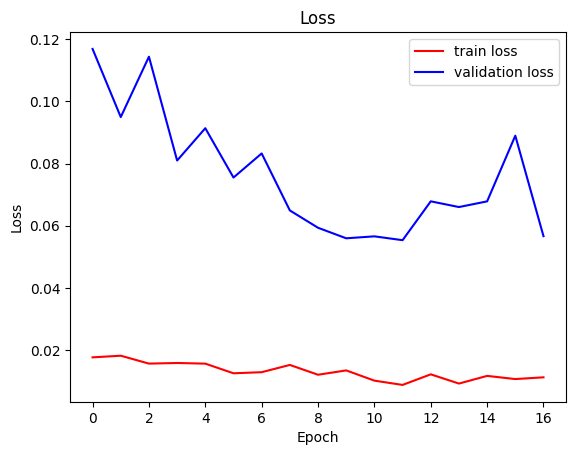

In [15]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history[10:], color = 'red', label = 'train loss')
plt.plot(val_loss_history[10:], color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

564/564 [==============================] - 2s 4ms/step
predicted_price shape: (18030, 2)
real_price shape: (18030, 2)


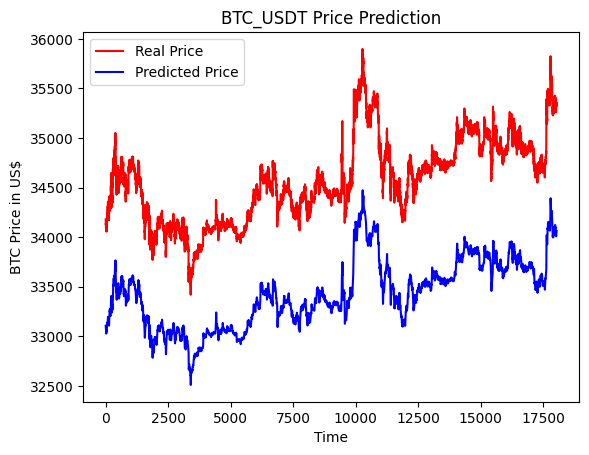

In [42]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)[:-predicting_points]
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)[:-predicting_points]
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price[:,0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[:,0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

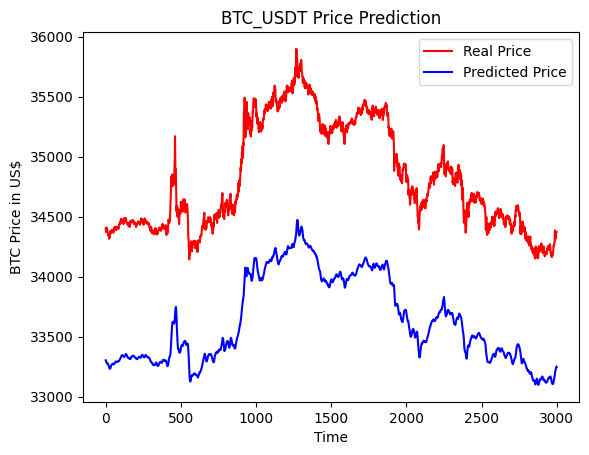

In [46]:
plt.plot(real_price[9000:12000, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[9000:12000, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

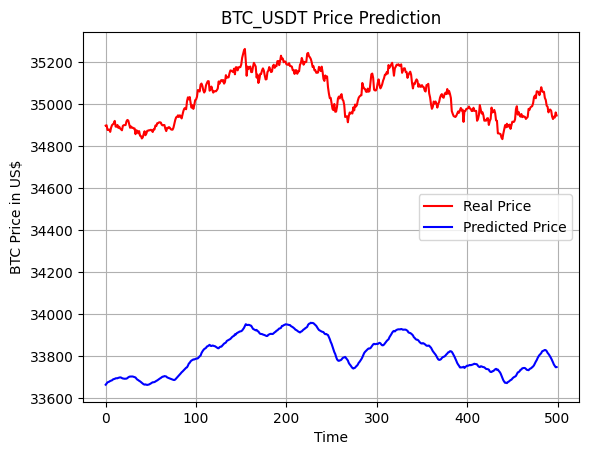

In [18]:
plt.plot(real_price[16000:16500, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[16000:16500, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

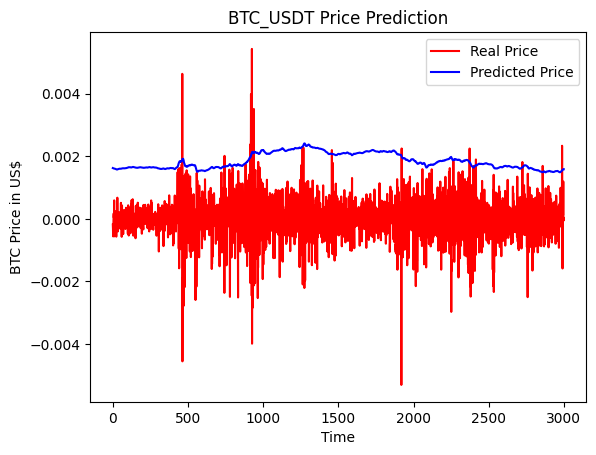

In [47]:
plt.plot(real_price[9000:12000, 1], color = 'red', label = 'Real Price')
plt.plot(predicted_price[9000:12000, 1], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

In [49]:
def f1(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(y_pred[:, 1])
    
    
    tp = K.sum(K.cast(w_true*w_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-w_true)*(1-w_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-w_true)*w_pred, 'float'), axis=0)
    fn = K.sum(K.cast(w_true*(1-w_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1), w_true, w_pred

In [50]:
f1, w_true, w_pred  = f1(real_price[:10],predicted_price[:10])

In [51]:
w_true

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1])

In [52]:
w_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])